# GoogLeNet
VGG（第二）和GoogleNet（第一）同年在一个比赛中出现的。<br>
【相同】
1. 把多个层进行模块化分装，不再单单看一个卷积层带来的效果
2. 克服因为网络逐渐变深带来的过拟合<br>

【不同】
1. G使用不同大小的卷积核(1,1),(3,3),(5,5)。（VGG全部是(3,3)）
2. G利用NiN(Network in network)的思想，将全连接层--> (1,1)卷积层
3. G中引入了inception块，使网络呈现出一定的并行结构。（主要辅助分类器的存在）<br>

【辅助分类器】
对某些inception层的输出同样做softmax分类；将两个辅助分类器的损失乘以权重（论文中是0.3）加到网络的整体损失上，再进行反向传播。

# 加载扩展包

In [1]:
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm

# 云盘挂载

In [2]:
from google.colab import drive
drive.mount('/gdrive') ## mount drive

Mounted at /gdrive


# 数据准备

In [3]:
"""准备好训练和测试集"""
# 从PIL图像 --> Tensor 
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
    "val": transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])}
# 数据集的位置
file = '/gdrive/My Drive/Pytorch/flower_data/' 

# train_load 设置
train_dataset = datasets.ImageFolder(root=file+"train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)
batch_size = 32

# number of workers[暂时理解为可以加快速度，但内存消耗大]
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=nw)

# Validate_load 设置
validate_dataset = datasets.ImageFolder(root=file+"val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, 
                                              shuffle=False,
                                              num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                        val_num))

"""构建训练函数"""
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    batch_total_loss = 0.0
    num_batch = len(train_loader) 

    train_bar = tqdm(train_loader) #加载了一个进度条，要用到循环里面去

    for batch_idx, (data, label) in enumerate(train_bar):
        data, label = data.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()

        logits, aux_logits2, aux_logits1 = model(data)
        loss0 = criterion(logits, label)
        loss1 = criterion(aux_logits1, label)
        loss2 = criterion(aux_logits2, label)
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3

        loss.backward()
        optimizer.step()

        batch_total_loss += loss.item()

        # print statistics
        train_bar.desc = "[train epoch {}] \tloss:{:.3f}".format(epoch+1, loss)
    print('avg_train_loss: %.3f'% (batch_total_loss/num_batch))

"""构建测试函数"""
def val(model, device, test_loader, epoch):
    model.eval()
    num_acc = 0.0  # accumulate accurate number / epoch

    with torch.no_grad():
        val_bar = tqdm(validate_loader)
        
        for val_data, val_label in val_bar:
            val_data, val_label = val_data.to(DEVICE), val_label.to(DEVICE)

            outputs = model(val_data)

            # 找到概率最大的下标
            predict_y = torch.max(outputs, dim=1)[1]

            # torch.eq()比较是否相同，返回T/F
            num_acc += torch.eq(predict_y, val_label).sum().item() 

            val_bar.desc = "Validate: "

    val_accurate = num_acc / val_num
    print('[epoch %d] val_accuracy: %.3f' % (epoch + 1, val_accurate))


Using 2 dataloader workers every process
using 3306 images for training, 364 images for validation.


# GoogLeNet 网络

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False) -> None:
        super(GoogLeNet, self).__init__()

        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True) #采用向上取整的方式

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        # The output size (H x W). The number of output features is equal to the number of input planes.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):  # 权重初始化的选择，对后续的网络准确率有很大的影响
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 输入图像：N x 3 x 224 x 224
        x = self.conv1(x)
        x = self.maxpool1(x)

        # N x 64 x 56 x 56
        x = self.conv2(x) #(1,1)的卷积核
        x = self.conv3(x)
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # 辅助分类器,图像预测不需要【model.eval() 是模型的某些特定层开关】
        if self.aux1 and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)

        x = self.inception4d(x)
        if self.aux2 and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)

        # N x 832 x 7 x 7
        x = self.inception5a(x)
        x = self.inception5b(x)

        # N x 1024 x 7 x 7 -> N x 1024 x 1 x 1 相当于输出(1,1)的卷积层
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training:
            return x, aux2, aux1
        return x

class Inception(nn.Module):

    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int, #"red"先进行(1,1)降维
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
    ) -> None:
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2) ##这里官网给的是3，但是应该是5.不知道哪个是错的，先用5
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)  # 把每一层级联起来


class InceptionAux(nn.Module):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
    ) -> None:
        super(InceptionAux, self).__init__()
        
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14
        # aux2: N x 528 x 14 x 14
        # nn.AvgPool2d(kernel_size=5, stride=3)效果是一样的，输出size(4,4)
        x = F.adaptive_avg_pool2d(x, (4, 4))  
        # aux1: N x 512 x 4 x 4, 
        # aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = F.dropout(x, 0.7, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x


class BasicConv2d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return F.relu(x, inplace=True)

"""网络参数选择"""
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("using {} device.".format(DEVICE))

# 训练次数
EPOCHS = 30 

# 构建模型
model = GoogLeNet(num_classes=5, aux_logits=True, init_weights=True).to(DEVICE)

# 定义损失函数
criterion = nn.CrossEntropyLoss() 

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0003)

using cuda device.


# 主函数

In [5]:
def main():
    for epoch in range(EPOCHS):
        train(model, DEVICE, train_loader, optimizer, epoch)
        val(model, DEVICE, validate_loader, epoch)
    print('Finished Training')

    # 网络保存
    save_path = '/gdrive/My Drive/Pytorch/GoogLeNet/googlenet.pth'
    torch.save(model.state_dict(), save_path)

if __name__ == '__main__':  #主函数入口
    main()


avg_train_loss: 3.041



[epoch 1] val_accuracy: 0.478



avg_train_loss: 1.842



[epoch 2] val_accuracy: 0.591



avg_train_loss: 1.643



[epoch 3] val_accuracy: 0.569



avg_train_loss: 1.589



[epoch 4] val_accuracy: 0.538



avg_train_loss: 1.503



[epoch 5] val_accuracy: 0.607



avg_train_loss: 1.521



[epoch 6] val_accuracy: 0.657



avg_train_loss: 1.411



[epoch 7] val_accuracy: 0.676



avg_train_loss: 1.347



[epoch 8] val_accuracy: 0.723



avg_train_loss: 1.341



[epoch 9] val_accuracy: 0.665



avg_train_loss: 1.281



[epoch 10] val_accuracy: 0.703



avg_train_loss: 1.195



[epoch 11] val_accuracy: 0.747



avg_train_loss: 1.194



[epoch 12] val_accuracy: 0.684



avg_train_loss: 1.143



[epoch 13] val_accuracy: 0.725



avg_train_loss: 1.145



[epoch 14] val_accuracy: 0.777



avg_train_loss: 1.092



[epoch 15] val_accuracy: 0.777



avg_train_loss: 1.024



[epoch 16] val_accuracy: 0.736



avg_train_loss: 1.009



[epoch 17] val_accuracy: 0.673



avg_train_loss: 1.004



[epoch 18] val_accuracy: 0.745



avg_train_loss: 1.011



[epoch 19] val_accuracy: 0.728



avg_train_loss: 0.998



[epoch 20] val_accuracy: 0.755



avg_train_loss: 0.979



[epoch 21] val_accuracy: 0.745



avg_train_loss: 0.948



[epoch 22] val_accuracy: 0.736



avg_train_loss: 0.947



[epoch 23] val_accuracy: 0.794



avg_train_loss: 0.887



[epoch 24] val_accuracy: 0.769



avg_train_loss: 0.900



[epoch 25] val_accuracy: 0.753



avg_train_loss: 0.847



[epoch 26] val_accuracy: 0.772



avg_train_loss: 0.857



[epoch 27] val_accuracy: 0.750



avg_train_loss: 0.826



[epoch 28] val_accuracy: 0.758



avg_train_loss: 0.857



[epoch 29] val_accuracy: 0.797



avg_train_loss: 0.844



[epoch 30] val_accuracy: 0.788
Finished Training


# 预测

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

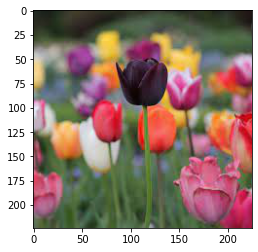

In [7]:
data_transform = transforms.Compose([transforms.Resize((227, 227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
# load image
img_path = '/gdrive/My Drive/Pytorch/flower_data/tulip.jpeg'
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
image = Image.open(img_path)
plt.imshow(image)

img = data_transform(image)  # img_tensor_size = C x H x W
# expand batch dimension 在第0个位置 1 x C x H x W, pytorch是按批次处理的
img = torch.unsqueeze(img, dim=0) 

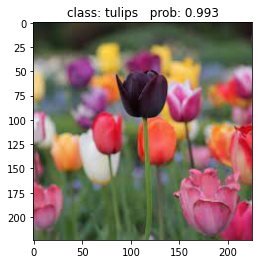

In [8]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载网络
model = GoogLeNet(num_classes=5, aux_logits=True, init_weights=True).to(DEVICE)

# load model weights
weights_path =  '/gdrive/My Drive/Pytorch/GoogLeNet/googlenet.pth'
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

# 预测
model.eval()
with torch.no_grad():
    # .cpu()是为了后面用numpy
    # squeeze掉batch dimension
    output = torch.squeeze(model(img.to(DEVICE))).cpu() 
    predict = torch.softmax(output, dim=0) # 给出每一类的概率值
    predict_cla = torch.argmax(predict).numpy() # 找到最大概率值的类

# 加载标签
json_path = '/gdrive/My Drive/Pytorch/flower_data/class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# 给出预测结果
print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                              predict[predict_cla].numpy())
plt.title(print_res)
plt.imshow(image)